## Preâmbulo

In [27]:
from itertools import chain, combinations
from docplex.mp.model import Model
from docplex.mp.relax_linear import LinearRelaxer
import networkx as nx   
import numpy as np
import matplotlib.pyplot as plt

def graphic(x, d, N):
    """
    Function to visualize the Traveling Salesman Problem (TSP) graphically.

    Parameters:
        x (numpy.ndarray): Distance matrix representing the pairwise distances between cities.
        d (list): List of cities with their corresponding distances.
        N (range): Range object representing the number of cities.

    Returns:
        None
    """

    edges = []
    for i in N:
        for j in N:
            if i != j and x[i, j] > 0.5:  # This is a tolerance value, it can be adjusted as needed
                edges.append((i, j, d[i - 1][j - 1]))

    G = nx.Graph()
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

seed = 43 # para reprodutibilidade experimental
np.random.seed(seed)

# PCV DFJ

In [28]:
def dfj(C : np.ndarray):
    """ 
        Cria um modelo do CPLEX segundo a formulacao DFJ(1954)
        Argumentos:
            C: Matriz de distâncias
        Retorna:
            z: valor da funcao objetivo
            x: solucao otima
            model: modelo docplex
            solution: solution docplex
    """
    n = len(C) # quantidade de cidades
    V = set(range(n)) # conjunto de cidades
    # cria um novo modelo
    model = Model('DFJ')
    # define as variaveis de decisao
    x = model.binary_var_dict(
        {(i + 1, j + 1) for i in range(n) for j in range(n)},
        name = 'x'
    )
    # adiciona a funcao objetivo
    model.minimize(
        model.sum(
            x[(i + 1), (j + 1)] * C[i][j] for i in range(n) for j in range(n)
        )
    )
    # adiciona os conjuntos de restricoes
    for i in range(n): # R1
        model.add_constraint(
            model.sum(
                x[(i + 1), (j + 1)] for j in range(n)
            ) == 1
        )
    for j in range(n): # R2
        model.add_constraint(
            model.sum(
                x[(i + 1), (j + 1)] for i in range(n)
            ) == 1
        )
    # R3
    for k in range(2, n):
        for S in combinations(
            V - {0}, k
        ):
            model.add_constraint(
                model.sum(
                    x[i, j] for i in S for j in S
                ) <= k - 1
            )
    # realiza a solucao do PCV pelo modelo DFJ
    solution = model.solve()
    z = model.solution.get_objective_value()
    x = solution.get_value_dict(x, keep_zeros = True, precision = 1)
    return z, x, model, solution

## PCV MTZ

In [29]:
def mtz(C : np.ndarray):
    """ 
        Cria um modelo do CPLEX segundo a formulacao MTZ(1960)
        Argumentos:
            C: Matriz de distâncias
        Retorna:
            z: valor da funcao objetivo
            x: solucao otima
            model: modelo docplex
            solution: solution docplex
    """
    n = len(C) # quantidade de cidades
    V = list(range(n)) # conjunto de cidades
    # cria um novo modelo
    model = Model('MTZ')
    # define as variaveis de decisao
    x = model.binary_var_dict(
        {(i + 1, j + 1) for i in range(n) for j in range(n)},
        name = 'x'
    )
    u = model.integer_var_dict(
        {(i + 1) for i in V[1:]},
        name = 'u'
    )
    # adiciona a funcao objetivo
    model.minimize(
        model.sum(
            x[(i + 1), (j + 1)] * C[i][j] for i in range(n) for j in range(n)
        )
    )
    # adiciona os conjuntos de restricoes
    for i in range(n): # R1
        model.add_constraint(
            model.sum(
                x[(i + 1), (j + 1)] for j in range(n)
            ) == 1
        )
    for j in range(n): # R2
        model.add_constraint(
            model.sum(
                x[(i + 1), (j + 1)] for i in range(n)
            ) == 1
        )
    # R3
    for i in V[1:]:
        for j in V[1:]:
            model.add_constraint(
                u[i + 1] - u[j + 1] + (n - 1) * (x[(i + 1),(j + 1)]) <= n - 2
            )
    # R4
    for i in V[1:]:
        model.add_constraint(
            u[i + 1] >= 1
        )
        model.add_constraint(
            u[i + 1] <= n - 1
        )
    # realiza a solucao do PCV pelo modelo MTZ
    solution = model.solve()
    z = model.solution.get_objective_value()
    x = solution.get_value_dict(x, keep_zeros = True, precision = 1)
    return z, x, model, solution

## PCV GG

In [30]:
def gg(C : np.ndarray):
    """ 
        Cria um modelo do CPLEX segundo a formulacao GG(1978)
        Argumentos:
            C: Matriz de distâncias
        Retorna:
            z: valor da funcao objetivo
            x: solucao otima
            model: modelo docplex
            solution: solution docplex
    """
    n = len(C) # quantidade de cidades
    V = list(range(n)) # conjunto de cidades
    # cria um novo modelo
    model = Model('GG')
    # define as variaveis de decisao
    x = model.binary_var_dict(
        {(i + 1, j + 1) for i in range(n) for j in range(n)},
        name = 'x'
    )
    g = model.integer_var_dict(
        {(i + 1, j + 1) for i in V for j in V},
        name = 'g'
    )
    # adiciona a funcao objetivo
    model.minimize(
        model.sum(
            x[(i + 1), (j + 1)] * C[i][j] for i in range(n) for j in range(n)
        )
    )
    # adiciona os conjuntos de restricoes
    for i in range(n): # R1
        model.add_constraint(
            model.sum(
                x[(i + 1), (j + 1)] for j in range(n)
            ) == 1
        )
    for j in range(n): # R2
        model.add_constraint(
            model.sum(
                x[(i + 1), (j + 1)] for i in range(n)
            ) == 1
        )
    # R3
    for i in V[1:]:
        model.add_constraint(
            model.sum(
                g[j + 1, i + 1] for j in range(n)
            ) - model.sum(
                g[i + 1, j + 1] for j in range(1, n)
            ) == 1
        )
    # R4
    for i in V:
        for j in V[1:]:
            model.add_constraint(
                g[i + 1, j + 1] <= (n - 1) * x[(i + 1), (j + 1)]
            )
    # realiza a solucao do PCV pelo modelo GG
    solution = model.solve()
    z = model.solution.get_objective_value()
    x = solution.get_value_dict(x, keep_zeros = True, precision = 1)
    return z, x, model, solution

## Exemplos de resoluções com visualizações gráficas para 15 Cidades

### Distâncias

In [31]:
C = np.random.randint(1,100,(15,15)) * 1.
np.fill_diagonal(C, np.inf)
n = len(C)
N = [i + 1 for i in range(n)]

### DFJ(1954) com tour e distância

Distancia total: 223.0


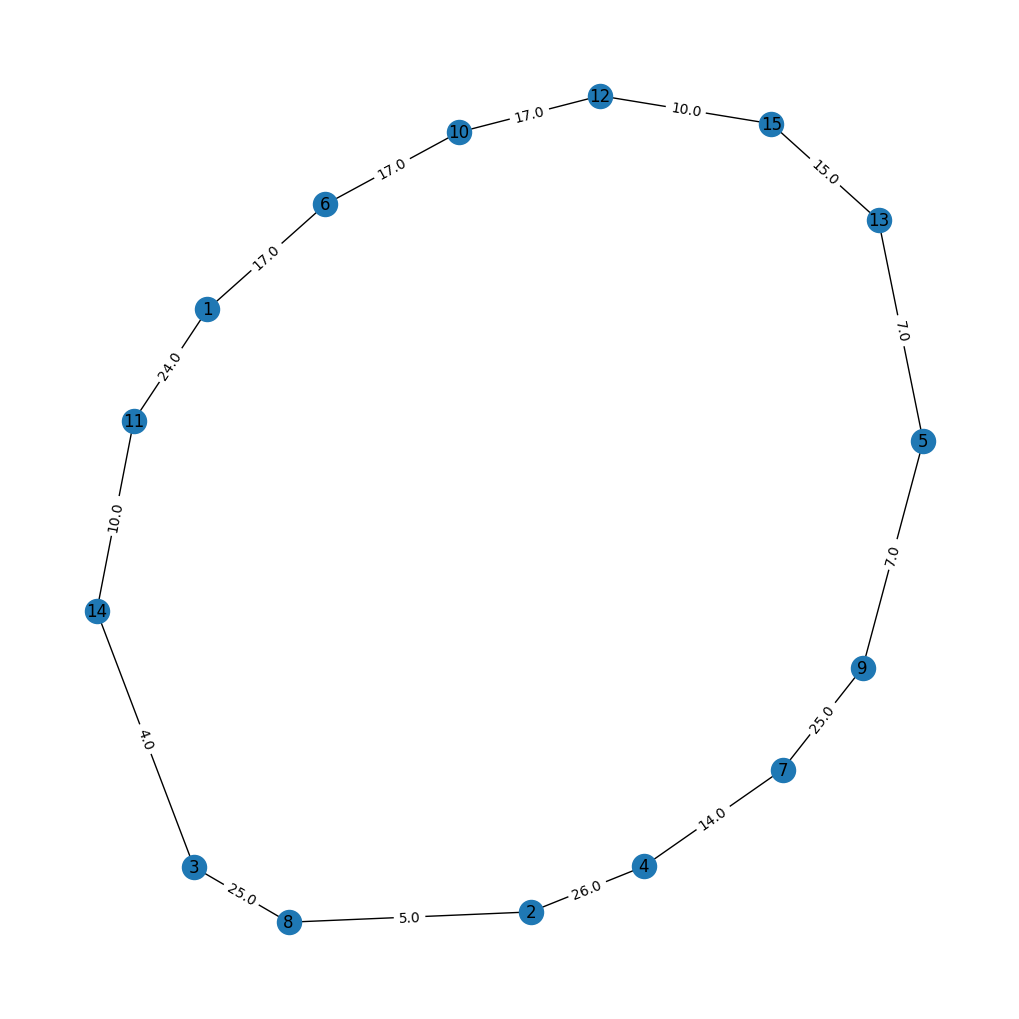

In [32]:
z, x, *_ = dfj(C)
print(f'Distancia total: {z}')
graphic(x, C, N)

### MTZ(1954) com tour e distância

Distancia total: 223.0


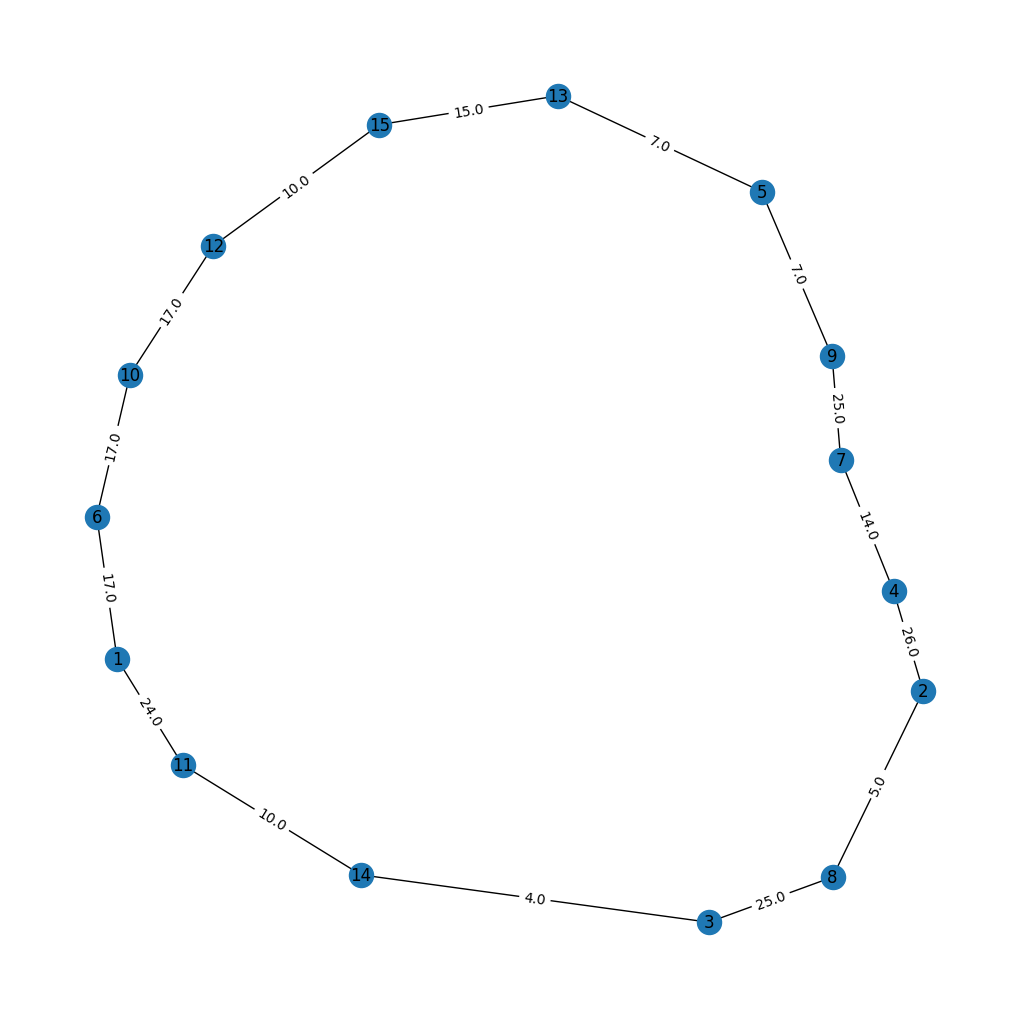

In [33]:
z, x, *_ = mtz(C)
print(f'Distancia total: {z}')
graphic(x, C, N)

### GG(1978) com tour e distância

Distancia total: 223.0


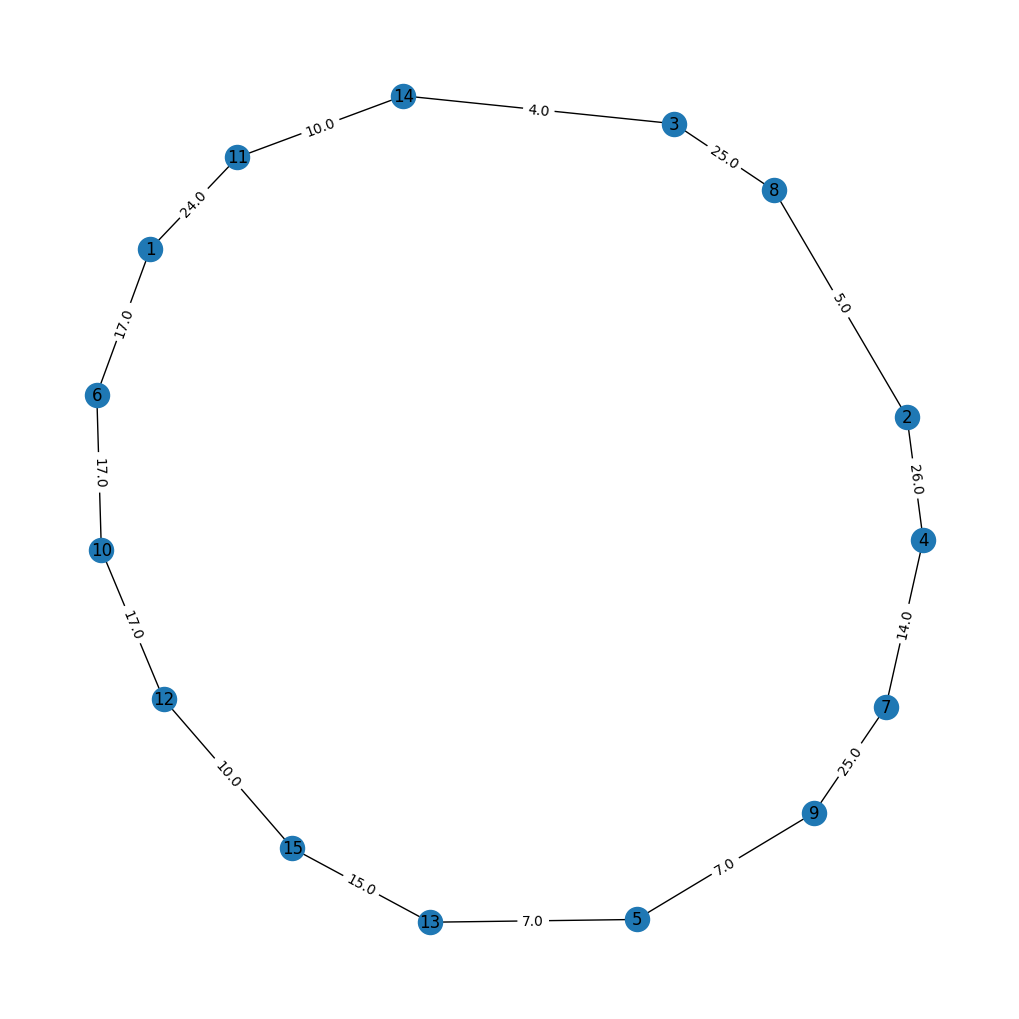

In [34]:
z, x, *_ = gg(C)
print(f'Distancia total: {z}')
graphic(x, C, N)

In [45]:
resultados = {}
lr = LinearRelaxer()

expoentes = range(3, 9)

for e in expoentes:
    n = 2**e
    resultados[n] = {
        'dfj' : {},
        'dfjlr': {},
        'mtz' : {},
        'mtzlr': {},
        'gg': {},
        'gglr': {}
    }
    for i in range(3): # 30 execucoes
        C = np.random.randint(1,100,(n,n)) * 1.
        np.fill_diagonal(C, np.inf)

        # FORMULACAO DFJ
        if e <= 4:
            z, x, dfjmodel, dfjsolution = dfj(C)
            # armazeno os resultados do DFJ inteiro
            resultados[n]['dfj'][i] = {
                'z': z,
                'time': dfjsolution.solve_details.time
            }
            # faço a relaxacao linear do DFJ
            dfjlr = lr.linear_relaxation(dfjmodel)
            dfjlrsol = dfjlr.solve()
            resultados[n]['dfjlr'][i] = {
                'z': dfjlrsol.objective_value,
                'time': dfjlrsol.solve_details.time
            }
        else:
            resultados[n]['dfj'][i] = {
                'z': np.nan,
                'time': np.inf
            }
            resultados[n]['dfjlr'][i] = {
                'z': np.nan,
                'time': np.inf
            }

        # FORMULACAO MTZ
        z, x, mtzmodel, mtzsolution = mtz(C)
        resultados[n]['mtz'][i] = {
            'z': z,
            'time': mtzsolution.solve_details.time
        }
        # relaxação linear do mtz
        mtzlr = lr.linear_relaxation(mtzmodel)
        mtzlrsol = mtzlr.solve()
        resultados[n]['mtzlr'][i] = {
            'z': mtzlrsol.objective_value,
            'time': mtzlrsol.solve_details.time
        }

        # FORMULACAO GG
        z, x, ggmodel, ggsolution = gg(C)
        resultados[n]['gg'][i] = {
            'z': z,
            'time': ggsolution.solve_details.time
        }
        # relaxação linear do GG
        gglr = lr.linear_relaxation(mtzmodel)
        gglrsol = gglr.solve()
        resultados[n]['gglr'][i] = {
            'z': gglrsol.objective_value,
            'time': gglrsol.solve_details.time
        }

In [47]:
import json
with open('resultados.json', 'w', encoding='utf-8') as f:
    json.dump(resultados, f, indent=4, ensure_ascii=False)

## GG com cortes e heurísticas desabilitados para 16, 32, 64, 128 cidades

In [70]:
np.random.seed(43)
print('n', 't_default', 't_nocuts', 't_noheur', sep = ',')
for n in range(4,8):
    C = np.random.randint(1,100,(2**n,2**n)) * 1.
    z, x, ggmodel, ggsolution = gg(C)
    default = ggsolution.solve_details.time
    _ = ggmodel.clone()
    
    _.parameters.mip.limits.cutsfactor.set(0) # desabilita cortes
    s = _.solve()
    nocuts = s.solve_details.time

    _ = _.clone()
    _.parameters.mip.strategy.heuristicfreq.set(-1) # desabilita heuristicas
    _.parameters.mip.strategy.rinsheur.set(-1) # desabilita heuristicas
    _.parameters.mip.strategy.fpheur.set(-1) # desabilita heuristicas
    _.parameters.mip.strategy.lbheur.set( 0) # desabilita heuristicas
    _.parameters.mip.strategy.probe.set(-1) # desabilita heuristicas
    s = _.solve()
    noheur = s.solve_details.time

    print(n, default, nocuts, noheur, sep = ',')

n,t_default,t_nocuts,t_noheur
4,0.3485848903656006,0.09581184387207031,0.09899616241455078
5,0.4402308464050293,0.4931149482727051,0.7705910205841064
6,5.780369997024536,13.939381837844849,29.87748908996582
7,221.2067289352417,232.8421471118927,172.5571219921112
